In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import torch
import os
import numpy as np
from skimage.io import imread
from torch.utils.data import Dataset
from torchvision import transforms
from utils.helpers import PATHS, masks_as_image, rle2bbox
import pandas as pd

In [2]:
# Get all
df = pd.read_csv(os.path.join(PATHS['root'], 'train_ship_segmentations_v2.csv'))
# Corrupted images
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
            '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
            'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
            'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg']
# Remove corrupted file
df = df[~df['ImageId'].isin(exclude_list)]

# Count number of ships for each image
ship_count_df = df.copy()
ship_count_df["Counts"] = ship_count_df["EncodedPixels"].map(lambda x:1 if isinstance(x,str) else 0)
ship_count_df = ship_count_df.groupby("ImageId").agg({ "Counts":"sum" }).reset_index()

ship_count_df

,ImageId,Counts
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0
...,...,...
192550,fffedbb6b.jpg,0
192551,ffff2aa57.jpg,0
192552,ffff6e525.jpg,0
192553,ffffc50b4.jpg,0


In [3]:
df_yolo = df.copy()

# Add bbox
df_yolo["Bbox"] = df_yolo["EncodedPixels"].apply(lambda x: rle2bbox(x,(768,768)) if isinstance(x, str) else [])
# Remove RLE
df_yolo.drop("EncodedPixels", axis=1, inplace=True)

# Add box area
df_yolo["BboxArea"] = df_yolo["Bbox"].map(lambda x:x[2]*768*x[3]*768 if len(x) > 0 else 0)

df_yolo

,ImageId,Bbox,BboxArea
0,00003e153.jpg,[],0.0
1,0001124c7.jpg,[],0.0
2,000155de5.jpg,"[0.5149739583333334, 0.62890625, 0.046875, 0.1...",3708.0
3,000194a2d.jpg,"[0.625, 0.38671875, 0.026041666666666668, 0.02...",440.0
4,000194a2d.jpg,"[0.09830729166666667, 0.4967447916666667, 0.01...",153.0
...,...,...,...
231718,fffedbb6b.jpg,[],0.0
231719,ffff2aa57.jpg,[],0.0
231720,ffff6e525.jpg,[],0.0
231721,ffffc50b4.jpg,[],0.0


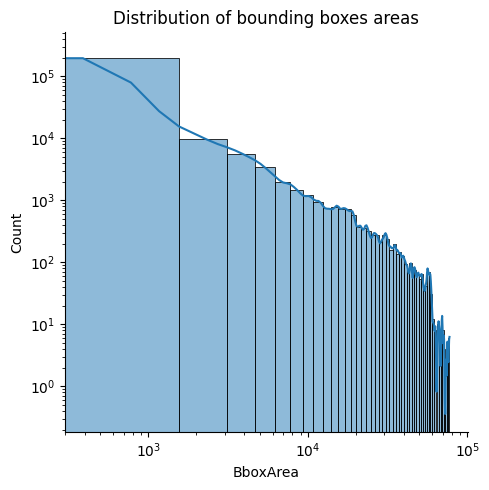

In [4]:
# %pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

area = df_yolo[df_yolo['Bbox'] != np.nan]
sns.displot(area["BboxArea"], bins=50, kde=True)
plt.xscale("log")
plt.yscale("log")
plt.title("Distribution of bounding boxes areas")
plt.tight_layout()

old = 231722 vs new = 81713


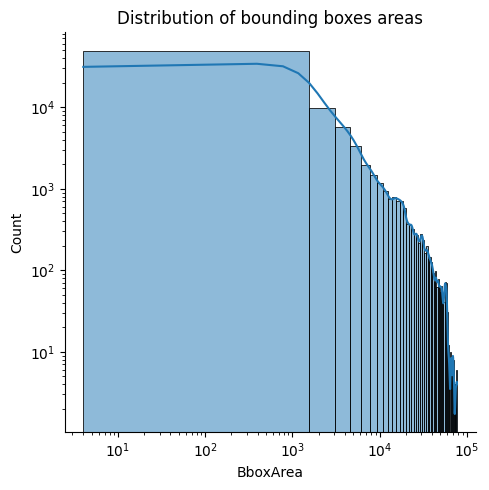

In [5]:
# Removing boxes which are less than PERCENTILE_THRESHOLD percentile
PERCENTILE_THRESHOLD = 5
df_yolo_cleaned = df_yolo[ df_yolo["BboxArea"] > np.percentile(df_yolo["BboxArea"], PERCENTILE_THRESHOLD) ]

area = df_yolo_cleaned[df_yolo_cleaned['Bbox'] != np.nan]
sns.displot(area["BboxArea"], bins=50, kde=True)
plt.xscale("log")
plt.yscale("log")
plt.title("Distribution of bounding boxes areas")
plt.tight_layout()

print(f"old = {len(df_yolo)} vs new = {len(df_yolo_cleaned)}")

,ImageId,Counts
0,b8c41c25f.jpg,0
1,2cf3bc2ce.jpg,0
2,144f5a0c6.jpg,0
3,47b0a44f8.jpg,0
4,9c8767de1.jpg,0
...,...,...
26447,74150366c.jpg,15
26448,557cc16f1.jpg,15
26449,b8a732575.jpg,15
26450,8da0bfee5.jpg,15


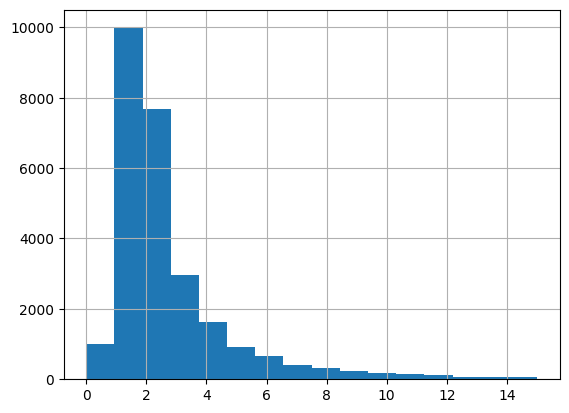

In [6]:
# Since the data set volumn is very high, we are downsampling to select 1000 images from each of the classes (where more than 1000)

def sample_fn(x):
    MAX_SAMPLES_NO_SHIPS = 1000
    MAX_SAMPLES = 10000

    # Undersample no ships images by 1000
    if (x.Counts == 0).all():
        return x.sample(MAX_SAMPLES_NO_SHIPS) 
    # Undersample images with ships (limit number to MAX_SAMPLES)
    else:
        return x.sample(min(len(x), MAX_SAMPLES)) 

balanced_df = ship_count_df.groupby("Counts")[['ImageId', 'Counts']].apply(sample_fn).reset_index(drop=True)

balanced_df["Counts"].hist(bins=16)
balanced_df

In [7]:
# Creating dataframe for Bounding boxes for the images in Balanced_df
balanced_bbox = df_yolo.merge(balanced_df[["ImageId"]], how ="inner", on = "ImageId")

balanced_bbox

,ImageId,Bbox,BboxArea
0,000194a2d.jpg,"[0.625, 0.38671875, 0.026041666666666668, 0.02...",440.0
1,000194a2d.jpg,"[0.09830729166666667, 0.4967447916666667, 0.01...",153.0
2,000194a2d.jpg,"[0.3665364583333333, 0.23372395833333334, 0.01...",517.0
3,000194a2d.jpg,"[0.09765625, 0.5032552083333334, 0.00130208333...",6.0
4,000194a2d.jpg,"[0.4557291666666667, 0.244140625, 0.0247395833...",722.0
...,...,...,...
65614,ffef7c3f3.jpg,"[0.818359375, 0.2786458333333333, 0.0130208333...",170.0
65615,fff1bdeea.jpg,"[0.8515625, 0.42578125, 0.013020833333333334, ...",60.0
65616,fffcb6464.jpg,"[0.41796875, 0.08463541666666667, 0.0260416666...",1240.0
65617,fffd924fb.jpg,"[0.189453125, 0.24544270833333334, 0.006510416...",25.0


In [8]:
from sklearn.model_selection import train_test_split

train_ids, val_ids = train_test_split(ship_count_df, test_size=0.05, stratify=ship_count_df['Counts'], random_state=42)

train_df = pd.merge(balanced_bbox, train_ids)
valid_df = pd.merge(balanced_bbox, val_ids)

print(train_df.size)
print(valid_df.size)

print(val_ids)

249232
13244
              ImageId  Counts
105045  8bb52f282.jpg       1
67752   5a24af8e4.jpg       1
161648  d6fb18ab5.jpg       0
97918   82434d348.jpg       9
189744  fc42f88ab.jpg       0
...               ...     ...
35234   2ed260301.jpg       5
186752  f86348f1e.jpg       1
168254  dfca142ed.jpg       0
62585   535df31f4.jpg       0
189657  fc25e7f52.jpg       0

[9628 rows x 2 columns]


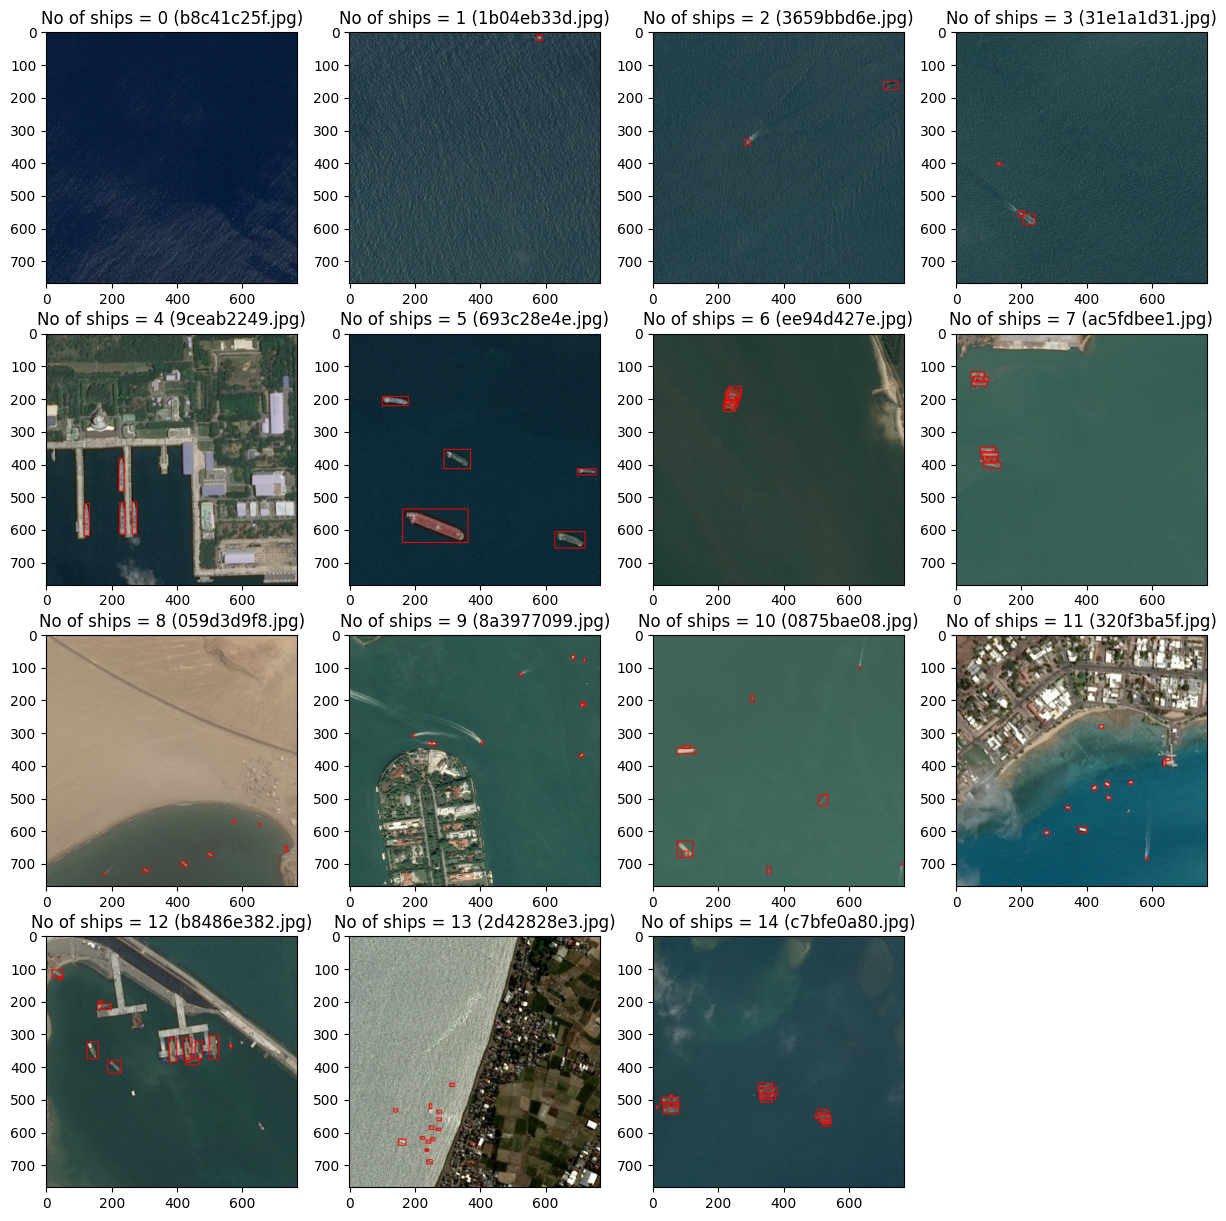

In [11]:
import cv2

# Visualizing the bounding boxes and images
path = PATHS['train']
plt.figure(figsize =(15,15))

for i in range(15):
    imageid = balanced_df[balanced_df.Counts == i]['ImageId'].iloc[0]

    image = np.array(cv2.imread(path + '/' + imageid)[:,:,::-1])

    if i>0:
        bbox = balanced_bbox[balanced_bbox.ImageId==imageid]["Bbox"]
        
        for items in bbox:
            Xmin  = int((items[0]-items[3]/2)*768)
            Ymin  = int((items[1]-items[2]/2)*768)
            Xmax  = int((items[0]+items[3]/2)*768)
            Ymax  = int((items[1]+items[2]/2)*768)
            cv2.rectangle(image,
                          (Xmin,Ymin),
                          (Xmax,Ymax),
                          (255,0,0),
                          thickness = 2)
    plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title("No of ships = {} ({})".format(i, imageid))

In [ ]:
train_df

,ImageId,Bbox,BboxArea,Counts
0,000194a2d.jpg,"[0.625, 0.38671875, 0.026041666666666668, 0.02...",440.0,5
1,000194a2d.jpg,"[0.09830729166666667, 0.4967447916666667, 0.01...",153.0,5
2,000194a2d.jpg,"[0.3665364583333333, 0.23372395833333334, 0.01...",517.0,5
3,000194a2d.jpg,"[0.09765625, 0.5032552083333334, 0.00130208333...",6.0,5
4,000194a2d.jpg,"[0.4557291666666667, 0.244140625, 0.0247395833...",722.0,5
...,...,...,...,...
62309,ffef7c3f3.jpg,"[0.818359375, 0.2786458333333333, 0.0130208333...",170.0,3
62310,fff1bdeea.jpg,"[0.8515625, 0.42578125, 0.013020833333333334, ...",60.0,1
62311,fffcb6464.jpg,"[0.41796875, 0.08463541666666667, 0.0260416666...",1240.0,1
62312,fffd924fb.jpg,"[0.189453125, 0.24544270833333334, 0.006510416...",25.0,2


In [ ]:
imageid_with_no_ships = train_df[train_df.Counts == 0]['ImageId'].iloc[0]
imageid_with_3_ships = train_df[train_df.Counts == 3]['ImageId'].iloc[0]

train_df[train_df['ImageId'] == imageid_with_3_ships]

,ImageId,Bbox,BboxArea,Counts
45,002943412.jpg,"[0.5247395833333334, 0.2936197916666667, 0.027...",504.0,3
46,002943412.jpg,"[0.3352864583333333, 0.8548177083333334, 0.162...",17875.0,3
47,002943412.jpg,"[0.396484375, 0.216796875, 0.06901041666666667...",3869.0,3


In [ ]:
def get_bboxes_img(id):
    group = train_df[train_df['ImageId'] == id].groupby('ImageId')
    bboxes = [el['Bbox'].values.tolist() for _, el in group][0]
    return bboxes


print("Image with no ships:")
print(get_bboxes_img(imageid_with_no_ships))

print("\nImage with 3 ships:")
print(get_bboxes_img(imageid_with_3_ships))

Image with no ships:
[[]]

Image with 3 ships:
[[np.float64(0.5247395833333334), np.float64(0.2936197916666667), np.float64(0.02734375), np.float64(0.03125)], [np.float64(0.3352864583333333), np.float64(0.8548177083333334), np.float64(0.16276041666666666), np.float64(0.18619791666666666)], [np.float64(0.396484375), np.float64(0.216796875), np.float64(0.06901041666666667), np.float64(0.09505208333333333)]]


In [ ]:
bboxes_3_ships = torch.tensor(get_bboxes_img(imageid_with_3_ships))
for box in bboxes_3_ships:
    print(box)
    print(len(box))
    print(box.tolist())

print("-----------")

bboxes_no_ships = torch.tensor(get_bboxes_img(imageid_with_no_ships))
for box in bboxes_no_ships:
    print(box.tolist())

tensor([0.5247, 0.2936, 0.0273, 0.0312], dtype=torch.float64)
4
[0.5247395833333334, 0.2936197916666667, 0.02734375, 0.03125]
tensor([0.3353, 0.8548, 0.1628, 0.1862], dtype=torch.float64)
4
[0.3352864583333333, 0.8548177083333334, 0.16276041666666666, 0.18619791666666666]
tensor([0.3965, 0.2168, 0.0690, 0.0951], dtype=torch.float64)
4
[0.396484375, 0.216796875, 0.06901041666666667, 0.09505208333333333]
-----------
[]


In [ ]:
def bboxes2cells(bboxes: list, S=7, C=1, B=2):
    """
    Convert bboxes to cells (if this image has to ships bboxes = [] => label_matrix will stay zeroed)
    """

    label_matrix = torch.zeros((S, S, C + 5 * B))
    for box in bboxes:
        if (len(box) == 0):
            continue

        x, y, height, width = box.tolist()

        # i,j represents the cell row and cell column
        i, j = int(S * y), int(S * x)
        x_cell, y_cell = S * x - j, S * y - i

        """
        Calculating the width and height of cell of bounding box,
        relative to the cell is done by the following, with
        width as the example:
        
        width_pixels = (width*self.image_width)
        cell_pixels = (self.image_width)
        
        Then to find the width relative to the cell is simply:
        width_pixels/cell_pixels, simplification leads to the
        formulas below.
        """
        width_cell, height_cell = (width * S, height * S)

        # If no object already found for specific cell i,j
        # Note: This means we restrict to ONE object per cell!
        if label_matrix[i, j, C] == 0:
            # Set that there exists an object
            label_matrix[i, j, C] = 1

            # Box coordinates
            box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])

            label_matrix[i, j, 4:8] = box_coordinates

            # Set one hot encoding for class_label
            label_matrix[i, j, 0] = 1

    return label_matrix